# Dependencies and Data Loading

In [19]:
import os
import sys
import time
import numpy as np
import random
import pandas as pd
import scipy.io as sio
from collections import Counter
from itertools import product
from scipy.io import loadmat
import tensorflow as tf
from keras.utils import np_utils
from tensorflow.keras import optimizers,backend
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense, Flatten, Lambda, concatenate
from keras.layers.convolutional import Convolution1D,MaxPooling1D
from keras.callbacks import ModelCheckpoint
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [20]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# load training and ground truth data 
from scipy.io import loadmat

# synthetic training data
filename = '/content/drive/My Drive/Manuscript_EJNMMI_2021/Github/Traindata_synthetic.mat'
input = loadmat(filename)
input_spectra = input['spectra_syn_train']
labels = input['pH_labels_syn_train']


In [23]:
# load testdata - synthetic spectra
filename = '/content/drive/My Drive/Manuscript_EJNMMI_2021/Github/Testdata_synthetic.mat'
test_aug = loadmat(filename)
test_input_spectra_aug = test_aug['spectra_syn_test']
test_labels_aug = test_aug['pH_labels_syn_test']

# load testdata - kidney
filename = '/content/drive/My Drive/Manuscript_EJNMMI_2021/Github/Testdata_kidney.mat'
test = loadmat(filename)
test_input_spectra = test['spectra_kidney_test']
test_labels = test['pH_labels_kidney_test']

In [24]:
display(test_input_spectra_aug.shape)
display(test_labels_aug.shape)
display(test_input_spectra.shape)
display(test_labels.shape)

(20, 1024)

(20, 3)

(8, 1024)

(8, 3)

# Preprocessing

In [25]:
#train-val split
X_train, X_val, y_train, y_val = train_test_split(input_spectra, labels, test_size=0.15, random_state=13)

X_train = np.array(X_train).astype('float32')
X_train = X_train.reshape(X_train.shape + (1,))
X_val = np.array(X_val).astype('float32')
X_val = X_val.reshape(X_val.shape + (1,))

X_test = np.array(test_input_spectra).astype('float32')
X_test = X_test.reshape(X_test.shape + (1,))
X_test_aug = np.array(test_input_spectra_aug).astype('float32')
X_test_aug = X_test_aug.reshape(X_test_aug.shape + (1,))

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(test_labels)
y_test_aug = np.array(test_labels_aug)

display(X_train.shape)
display(y_train.shape)

print("Total of "+str(len(X_train))+" training samples.")
print("Total of "+str(len(X_val))+" validation samples.")


(8500, 1024, 1)

(8500, 3)

Total of 8500 training samples.
Total of 1500 validation samples.


Total of 8500 training samples.
Total of 1500 validation samples.


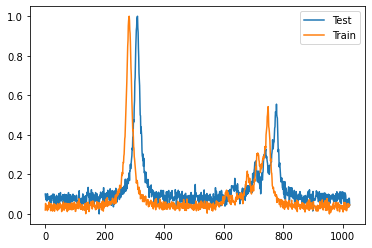

In [26]:
# print("Total of "+str(num_classes)+" classes.")
displayind = 2

print("Total of "+str(len(X_train))+" training samples.")
print("Total of "+str(len(X_val))+" validation samples.")
plt.plot(X_train[displayind],label='input')
plt.plot(X_val[displayind],label='ground truth')
plt.legend(['Test', 'Train'], loc='upper right')
plt.show()

# Model Architecture

In [27]:
def mapping_to_target_range( x, target_min=6.32, target_max=7.44) :
    x02 = backend.tanh(x) + 1 # x in range(0,2)
    scale = ( target_max-target_min )/2.
    return  x02 * scale + target_min

In [28]:
# default random initialization for weights
backend.clear_session()

model = Sequential()
model.add(Convolution1D(filters=4, kernel_size=300, padding='same', input_shape=(1024,1), activation='relu'))
model.add(MaxPooling1D())

model.add(Convolution1D(filters=4, kernel_size=150, padding='same', activation='relu'))
model.add(MaxPooling1D())

model.add(Convolution1D(filters=8, kernel_size=50, padding='same', activation='relu'))
model.add(MaxPooling1D())

model.add(Convolution1D(filters=8, kernel_size=20, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.10))

model.add(Flatten())
model.add(Dense(3,activation=mapping_to_target_range))
nadam = optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss='mean_squared_error', optimizer=nadam)

print(model.summary())
print("CNN Model created.")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1024, 4)           1204      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 512, 4)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 512, 4)            2404      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 256, 4)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 256, 8)            1608      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 128, 8)           0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


# Training

In [29]:
#Params
epochs = 400
batch_size = 200

best_model_file = '/content/drive/My Drive/weights/KidNeYronal_model_cnn-s.h5'
start = time.time()

best_model = ModelCheckpoint(best_model_file, monitor='loss', verbose = 1, save_best_only=True, save_weights_only=False)
hist = model.fit(X_train,
                 y_train,
                 validation_data=(X_val, y_val),  
                 epochs=epochs,
                 batch_size=batch_size,
                 callbacks = [best_model],
                 shuffle = True,
                 verbose=1)

print("training time: ", time.time() - start)
print("done")

Epoch 1/400
43/43 [==============================] - ETA: 0s - loss: 0.0113
Epoch 00001: loss improved from inf to 0.01134, saving model to /content/drive/My Drive/weights/KidNeYronal_model_cnn-s.h5
43/43 [==============================] - 13s 61ms/step - loss: 0.0113 - val_loss: 0.0023
Epoch 2/400
43/43 [==============================] - ETA: 0s - loss: 0.0027
Epoch 00002: loss improved from 0.01134 to 0.00270, saving model to /content/drive/My Drive/weights/KidNeYronal_model_cnn-s.h5
43/43 [==============================] - 2s 47ms/step - loss: 0.0027 - val_loss: 0.0017
Epoch 3/400
43/43 [==============================] - ETA: 0s - loss: 0.0024
Epoch 00003: loss improved from 0.00270 to 0.00244, saving model to /content/drive/My Drive/weights/KidNeYronal_model_cnn-s.h5
43/43 [==============================] - 2s 46ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 4/400
42/43 [============================>.] - ETA: 0s - loss: 0.0021
Epoch 00004: loss improved from 0.00244 to 0.00214, sa

(0.0, 0.01)

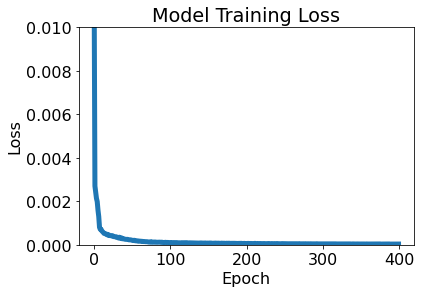

In [30]:
plt.rcParams.update({'font.size': 16})
plt.plot(hist.history['loss'], linewidth = 5)
plt.title('Model Training Loss')
plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.ylim(top=0.01,bottom=0) 

(0.0, 0.005)

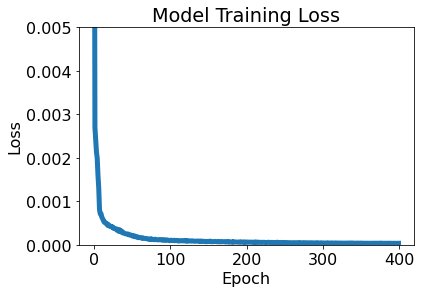

In [31]:
plt.plot(hist.history['loss'], linewidth = 5)
plt.title('Model Training Loss')
plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.ylim(top=0.005,bottom=0) 

(0.0, 0.01)

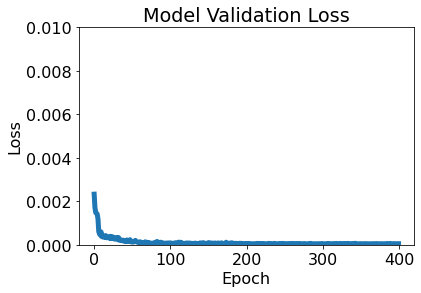

In [32]:
# 4
plt.plot(hist.history['val_loss'], linewidth = 5)
plt.title('Model Validation Loss')
plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.ylim(top=0.01,bottom=0) 


(0.0, 0.005)

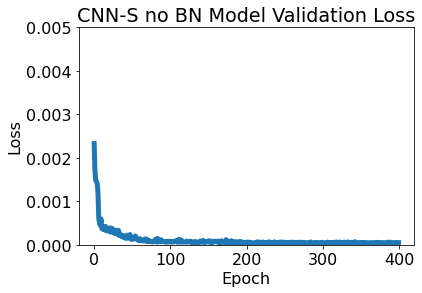

In [33]:
plt.plot(hist.history['val_loss'], linewidth = 5)
plt.title('CNN-S no BN Model Validation Loss')
plt.ylabel('Loss'), plt.xlabel('Epoch')
plt.ylim(top=0.005,bottom=0) 

# Testing Model Accuracy - Kidney data

In [34]:
predict = model.predict(X_test)
dis_index = 0     #index for the test data

In [35]:
def plot_predict_gt(predict_aug,y_test_aug):
  predict_output = pd.DataFrame({'predict':predict_aug,'ground truth':y_test_aug})
  predict_output = pd.DataFrame.transpose(predict_output)
  print('test: ',dis_index+1)
  print(predict_output)
  plt.figure()
  plt.plot(X_test[dis_index,:] )
  plt.title('spect= %i' %(dis_index+1))
  plt.ylabel('Intensity')
  print('\n')

test:  1
                     0         1        2
predict       7.394995  7.064244  6.53034
ground truth  7.429000  7.146000  6.73900


test:  2
                     0         1         2
predict       7.395538  7.079838  6.517441
ground truth  7.363000  7.103000  6.414000


test:  3
                     0         1         2
predict       7.402622  7.077892  6.539522
ground truth  7.332000  7.118000  6.381000


test:  4
                     0         1        2
predict       7.415376  7.112167  6.53432
ground truth  7.395000  6.970000  6.32600


test:  5
                     0         1         2
predict       7.419519  7.126987  6.711895
ground truth  7.351000  7.166000  6.750000


test:  6
                     0         1         2
predict       7.414914  7.107968  6.503493
ground truth  7.396000  7.045000  6.529000


test:  7
                     0         1         2
predict       7.394394  7.065716  6.551112
ground truth  7.431000  7.150000  6.768000


test:  8
                 

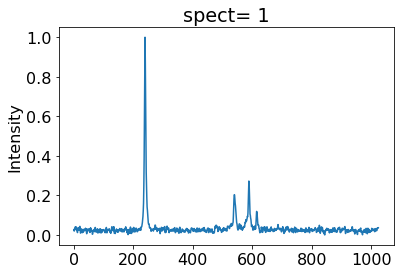

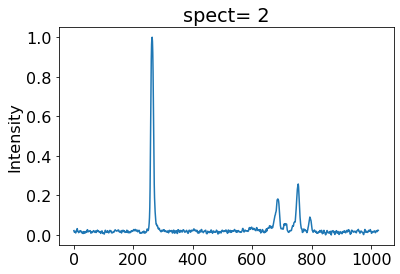

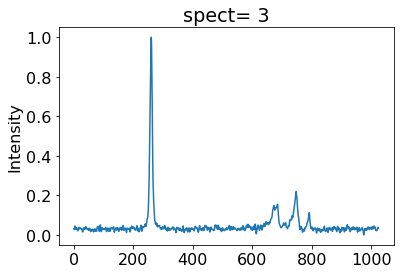

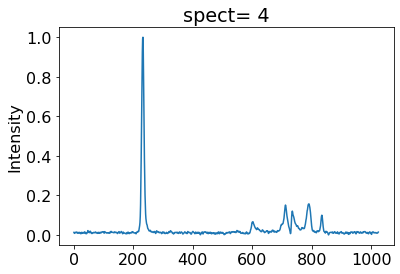

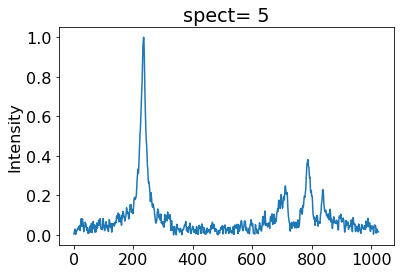

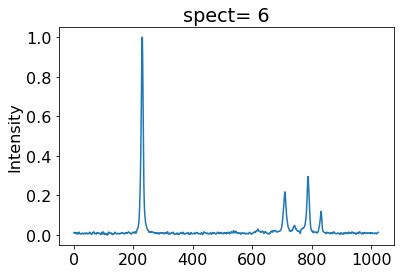

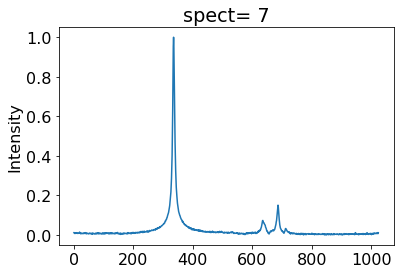

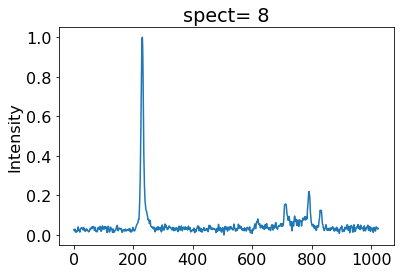

In [36]:
dis_index = 0
for idx in range(len(predict)):
  plot_predict_gt(predict[dis_index,:],y_test[dis_index,:])
  dis_index +=1

# Testing Model Accuracy - Synthetic data


In [37]:
predict_aug = model.predict(X_test_aug)

In [38]:
def print_predict_gt(predict_aug,y_test_aug):
  predict_output = pd.DataFrame({'predict':predict_aug,'ground truth':y_test_aug})
  predict_output = pd.DataFrame.transpose(predict_output)
  print('test: ',dis_index+1)
  print(predict_output)

In [39]:
dis_index = 0
for idx in range(len(predict_aug)):
  print_predict_gt(predict_aug[dis_index,:],y_test_aug[dis_index,:])
  dis_index +=1


test:  1
                     0         1         2
predict       7.367390  7.079638  6.522379
ground truth  7.366038  7.071987  6.522446
test:  2
                     0         1         2
predict       7.401224  7.020373  6.732088
ground truth  7.440000  7.006862  6.779162
test:  3
                     0         1         2
predict       7.364036  7.103937  6.486602
ground truth  7.367518  7.109335  6.486110
test:  4
                     0         1         2
predict       7.402049  7.016421  6.525851
ground truth  7.393396  7.006035  6.516890
test:  5
                     0         1         2
predict       7.395607  7.056844  6.413689
ground truth  7.405328  7.071277  6.422578
test:  6
                     0         1         2
predict       7.384950  7.029316  6.572730
ground truth  7.375795  7.023096  6.567435
test:  7
                     0         1         2
predict       7.398113  7.054248  6.365424
ground truth  7.400738  7.062025  6.364269
test:  8
                     0   